<a href="https://colab.research.google.com/github/parth5757/Image_Calculator/blob/main/Gujarati_Digit_%26_Word_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gujarati_Digit_Classification_CNN

### needed Library

In [ ]:
import os
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, BatchNormalization, Input, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

### connect to drive and defining some required configrution

In [ ]:
drive.mount('/content/drive')
IMAGE_SIZE = 28        # matches your ANN notebook
NUM_CLASSES = 10
SEED = 42
BATCH_SIZE = 64
EPOCHS = 30            # you can raise if GPU available
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)

print("Loading images from:", BASE_DIR)

Mounted at /content/drive
Loading images from: /content/drive/My Drive/Gujarati_digit/


### load dataset into X_data, y_labels (grayscale)

In [ ]:
X_data = []
y_labels = []
start_time = time.time()

for label in range(NUM_CLASSES):
    folder_path = os.path.join(BASE_DIR, str(label))
    if not os.path.isdir(folder_path):
        print(f"Warning: folder for digit {label} not found at {folder_path}. Skipping.")
        continue

    image_files = glob.glob(os.path.join(folder_path, '*.png')) + glob.glob(os.path.join(folder_path, '*.jpg'))
    print(f"Found {len(image_files)} images for digit {label}.")
    for img_path in image_files:
        img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='grayscale')
        img_array = img_to_array(img)
        X_data.append(img_array)
        y_labels.append(label)

X_data = np.array(X_data, dtype='float32')
y_labels = np.array(y_labels, dtype='int32')
end_time = time.time()
print(f"Total images loaded: {X_data.shape[0]} in {end_time - start_time:.2f}s")

if X_data.shape[0] == 0:
    raise RuntimeError("No images loaded. Check BASE_DIR and file types.")


Found 2066 images for digit 0.
Found 2097 images for digit 1.
Found 1985 images for digit 2.
Found 2132 images for digit 3.
Found 2116 images for digit 4.
Found 2045 images for digit 5.
Found 1992 images for digit 6.
Found 1980 images for digit 7.
Found 2010 images for digit 8.
Found 2029 images for digit 9.
Total images loaded: 20452 in 553.20s


### preprocess and split

In [ ]:
X_data = X_data / 255.0
y_cat = to_categorical(y_labels, num_classes=NUM_CLASSES)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_cat, test_size=0.2, random_state=SEED, stratify=y_labels
)

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])
print("Input shape  :", INPUT_SHAPE)

Train samples: 16361
Test samples : 4091
Input shape  : (28, 28, 1)


### CNN model

In [ ]:
def create_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    model = Sequential([
        Input(shape=input_shape),

        # Block 1
        Conv2D(32, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Block 3 (optional deeper)
        Conv2D(128, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Global pooling + dense head
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = create_cnn()
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 158,442 (618.91 KB)

 Trainable params: 157,546 (615.41 KB)

 Non-trainable params: 896 (3.50 KB)

### callbacks and training


In [ ]:
checkpoint_path = 'cnn_best_weights.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
]

history = cnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.4975 - loss: 1.5733
Epoch 1: val_accuracy improved from -inf to 0.09713, saving model to cnn_best_weights.h5


231/231 ━━━━━━━━━━━━━━━━━━━━ 107s 439ms/step - accuracy: 0.4993 - loss: 1.5676 - val_accuracy: 0.0971 - val_loss: 5.2623 - learning_rate: 0.0010
Epoch 2/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9292 - loss: 0.2406
Epoch 2: val_accuracy improved from 0.09713 to 0.36836, saving model to cnn_best_weights.h5


231/231 ━━━━━━━━━━━━━━━━━━━━ 88s 383ms/step - accuracy: 0.9293 - loss: 0.2402 - val_accuracy: 0.3684 - val_loss: 2.5404 - learning_rate: 0.0010
Epoch 3/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9431 - loss: 0.1874
Epoch 3: val_accuracy improved from 0.36836 to 0.78314, saving model to cnn_best_weights.h5


231/231 ━━━━━━━━━━━━━━━━━━━━ 141s 380ms/step - accuracy: 0.9432 - loss: 0.1870 - val_accuracy: 0.7831 - val_loss: 0.6972 - learning_rate: 0.0010
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9800 - loss: 0.0700
Epoch 4: val_accuracy improved from 0.78314 to 0.98717, saving model to cnn_best_weights.h5


231/231 ━━━━━━━━━━━━━━━━━━━━ 144s 389ms/step - accuracy: 0.9800 - loss: 0.0700 - val_accuracy: 0.9872 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 5/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9837 - loss: 0.0573
Epoch 5: val_accuracy did not improve from 0.98717
231/231 ━━━━━━━━━━━━━━━━━━━━ 140s 380ms/step - accuracy: 0.9837 - loss: 0.0573 - val_accuracy: 0.9805 - val_loss: 0.0652 - learning_rate: 0.0010
Epoch 6/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9884 - loss: 0.0427
Epoch 6: val_accuracy did not improve from 0.98717
231/231 ━━━━━━━━━━━━━━━━━━━━ 150s 413ms/step - accuracy: 0.9884 - loss: 0.0427 - val_accuracy: 0.9633 - val_loss: 0.1081 - learning_rate: 0.0010
Epoch 7/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9836 - loss: 0.0533
Epoch 7: val_accuracy did not improve from 0.98717

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
231/231 ━━━━━━━━━━━━━━━━━━━━ 89s 384ms/step - accuracy: 0.9836 - loss: 

231/231 ━━━━━━━━━━━━━━━━━━━━ 88s 380ms/step - accuracy: 0.9911 - loss: 0.0304 - val_accuracy: 0.9927 - val_loss: 0.0209 - learning_rate: 5.0000e-04
Epoch 9/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9951 - loss: 0.0219
Epoch 9: val_accuracy improved from 0.99267 to 0.99633, saving model to cnn_best_weights.h5


231/231 ━━━━━━━━━━━━━━━━━━━━ 142s 380ms/step - accuracy: 0.9951 - loss: 0.0219 - val_accuracy: 0.9963 - val_loss: 0.0136 - learning_rate: 5.0000e-04
Epoch 10/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9954 - loss: 0.0167
Epoch 10: val_accuracy did not improve from 0.99633
231/231 ━━━━━━━━━━━━━━━━━━━━ 88s 379ms/step - accuracy: 0.9954 - loss: 0.0167 - val_accuracy: 0.9902 - val_loss: 0.0301 - learning_rate: 5.0000e-04
Epoch 11/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9921 - loss: 0.0255
Epoch 11: val_accuracy did not improve from 0.99633
231/231 ━━━━━━━━━━━━━━━━━━━━ 144s 385ms/step - accuracy: 0.9921 - loss: 0.0254 - val_accuracy: 0.5687 - val_loss: 2.1131 - learning_rate: 5.0000e-04
Epoch 12/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9940 - loss: 0.0183
Epoch 12: val_accuracy did not improve from 0.99633

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
231/231 ━━━━━━━━━━━━━━━━━━━━ 91s 396ms/step - accurac

231/231 ━━━━━━━━━━━━━━━━━━━━ 142s 382ms/step - accuracy: 0.9969 - loss: 0.0111 - val_accuracy: 0.9988 - val_loss: 0.0040 - learning_rate: 2.5000e-04
Epoch 16/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9969 - loss: 0.0100
Epoch 16: val_accuracy did not improve from 0.99878
231/231 ━━━━━━━━━━━━━━━━━━━━ 88s 382ms/step - accuracy: 0.9969 - loss: 0.0100 - val_accuracy: 0.9982 - val_loss: 0.0089 - learning_rate: 2.5000e-04
Epoch 17/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9947 - loss: 0.0184
Epoch 17: val_accuracy did not improve from 0.99878
231/231 ━━━━━━━━━━━━━━━━━━━━ 141s 380ms/step - accuracy: 0.9947 - loss: 0.0184 - val_accuracy: 0.9988 - val_loss: 0.0048 - learning_rate: 2.5000e-04
Epoch 18/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9964 - loss: 0.0135
Epoch 18: val_accuracy did not improve from 0.99878

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
231/231 ━━━━━━━━━━━━━━━━━━━━ 88s 381ms/step - accurac

### evaluation

In [ ]:
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Test Loss: {loss:.4f}")
print(f"CNN Test Accuracy: {acc*100:.2f}%")


CNN Test Loss: 0.0121
CNN Test Accuracy: 99.68%


### plot training curves


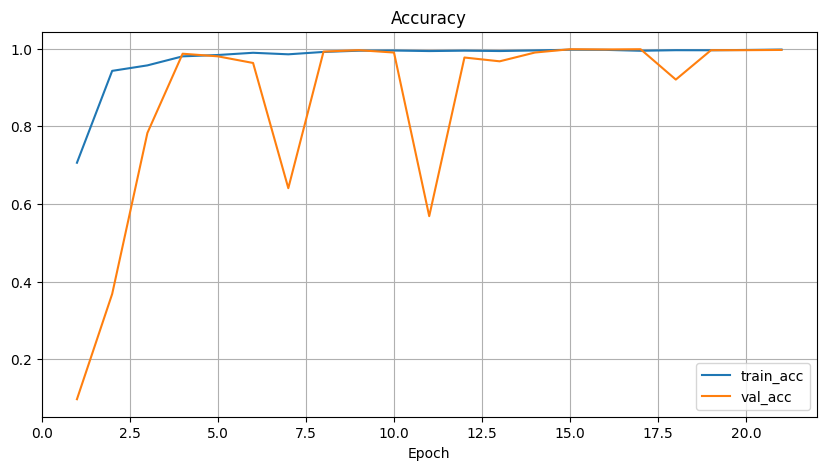

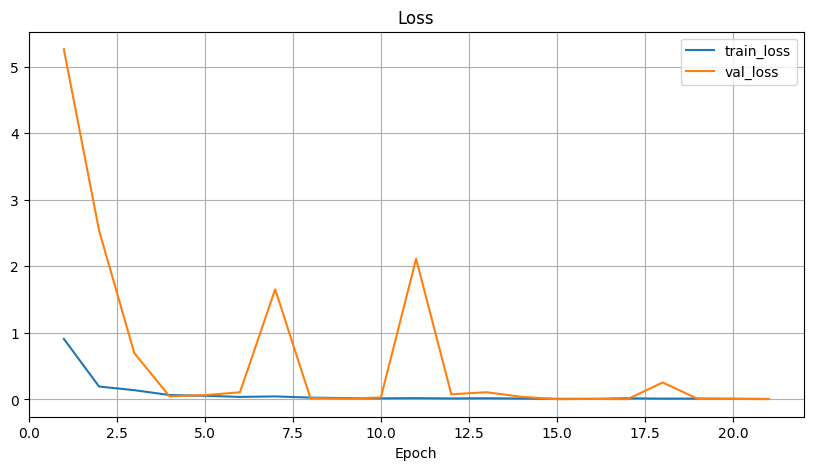

In [ ]:
hist_df = pd.DataFrame(history.history)
epochs = np.arange(1, len(hist_df)+1)

plt.figure(figsize=(10,5))
plt.plot(epochs, hist_df['accuracy'], label='train_acc')
plt.plot(epochs, hist_df['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs, hist_df['loss'], label='train_loss')
plt.plot(epochs, hist_df['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()


### classification report & confusion matrix

In [ ]:
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### given image prediction

In [ ]:
def predict_digit_cnn(image_path, model, image_size=IMAGE_SIZE):
    try:
        img = load_img(image_path, target_size=(image_size, image_size), color_mode='grayscale')
        arr = img_to_array(img) / 255.0
        arr = np.expand_dims(arr, axis=0)  # batch dim
        preds = model.predict(arr)
        pred_digit = np.argmax(preds, axis=1)[0]
        return pred_digit, preds[0]
    except FileNotFoundError:
        print(f"File not found: {image_path}")
        return None, None
    except Exception as e:
        print("Error during predict:", e)
        return None, None


In [ ]:
# predicted_digit, probs = predict_digit_cnn('Test3.jpg', cnn_model)
# print("Predicted:", predicted_digit, "Probs:", probs)

In [ ]:
cnn_model.save("Gujarati_Digit_CNN_Model.keras")

# Gujarati Words

In [ ]:
# connect google drive with the colab
from google.colab import drive
drive.mount('/content/drive')
import os

BASE_DIR = '/content/drive/MyDrive/MyDataSets/Gujarati/'
TRAIN_DIR = os.path.join(BASE_DIR, 'Train')
TEST_DIR = os.path.join(BASE_DIR, 'Test')

print(f"Base Directory: {BASE_DIR}")
folders = [d for d in os.listdir(BASE_DIR ) if os.path.isdir(os.path.join(BASE_DIR, d))]
print("Folder count:", len(folders))
print("Folders:", folders)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base Directory: /content/drive/MyDrive/MyDataSets/Gujarati/
Folder count: 385
Folders: ['A', 'AA', 'Ai', 'Ala', 'Alaa', 'Alai', 'Alam', 'Alau', 'Ale', 'Alee', 'Ali', 'Alo', 'Aloo', 'Alu', 'Am', 'Ana', 'Anaa', 'Anai', 'Anam', 'Anau', 'Ane', 'Anee', 'Ani', 'Ano', 'Anoo', 'Anu', 'Au', 'Ba', 'Baa', 'Bai', 'Bam', 'Bau', 'Be', 'Bee', 'Bha', 'Bhaa', 'Bhai', 'Bham', 'Bhau', 'Bhe', 'Bhee', 'Bhi', 'Bho', 'Bhoo', 'Bhu', 'Bi', 'Bo', 'Boo', 'Bu', 'Cha', 'Chaa', 'Chai', 'Cham', 'Chau', 'Che', 'Chee', 'Chha', 'Chhaa', 'Chhai', 'Chham', 'Chhau', 'Chhe', 'Chhee', 'Chhi', 'Chho', 'Chhoo', 'Chhu', 'Chi', 'Cho', 'Choo', 'Chu', 'DDO', 'DDa', 'DDaa', 'DDai', 'DDam', 'DDau', 'DDe', 'DDee', 'DDha', 'DDhaa', 'DDhai', 'DDham', 'DDhau', 'DDhe', 'DDhee', 'DDhi', 'DDho', 'DDhoo', 'DDhu', 'DDi', 'DDoo', 'DDu', 'Da', 'Daa', 'Dai', 'Dam', 'Dau', 'De', 'Dee', 'Dha', 'Dhaa', 'Dhai', 'Dham', '

In [ ]:
NUM_CLASSES = len(folders)

print("--- Updated Configuration for Gujarati Words ---")
print(f"BASE_DIR    : {BASE_DIR}")
print(f"IMAGE_SIZE  : {IMAGE_SIZE}")
print(f"NUM_CLASSES : {NUM_CLASSES}")
print(f"BATCH_SIZE  : {BATCH_SIZE}")
print(f"EPOCHS      : {EPOCHS}")
print(f"INPUT_SHAPE : {INPUT_SHAPE}")

--- Updated Configuration for Gujarati Words ---
BASE_DIR    : /content/drive/MyDrive/MyDataSets/Gujarati/
IMAGE_SIZE  : 28
NUM_CLASSES : 385
BATCH_SIZE  : 64
EPOCHS      : 30
INPUT_SHAPE : (28, 28, 1)


In [ ]:
X_data = []
y_labels = []
start_time = time.time()

# Ensure folders list is available and matches NUM_CLASSES
if len(folders) != NUM_CLASSES:
    raise ValueError("Number of folders found does not match NUM_CLASSES. Please check BASE_DIR setup.")

for label_idx in range(NUM_CLASSES):
    # Use the folder name from the 'folders' list for the current label index
    folder_name = folders[label_idx]
    folder_path = os.path.join(BASE_DIR, folder_name)

    if not os.path.isdir(folder_path):
        print(f"Warning: folder for label '{folder_name}' (index {label_idx}) not found at {folder_path}. Skipping.")
        continue

    image_files = glob.glob(os.path.join(folder_path, '*.png')) + glob.glob(os.path.join(folder_path, '*.jpg'))
    # print(f"Found {len(image_files)} images for label '{folder_name}'.") # Optional: uncomment for verbose output

    for img_path in image_files:
        try:
            img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='grayscale')
            img_array = img_to_array(img)
            X_data.append(img_array)
            y_labels.append(label_idx) # Append the numerical index as the label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

X_data = np.array(X_data, dtype='float32')
y_labels = np.array(y_labels, dtype='int32')
end_time = time.time()
print(f"Total images loaded: {X_data.shape[0]} in {end_time - start_time:.2f}s")

if X_data.shape[0] == 0:
    raise RuntimeError("No images loaded. Check BASE_DIR, folder structure, and file types.")


Total images loaded: 75762 in 2198.74s


In [ ]:
X_data = X_data / 255.0
y_cat = to_categorical(y_labels, num_classes=NUM_CLASSES)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_cat, test_size=0.2, random_state=SEED, stratify=y_labels
)

print("Train samples:", X_train.shape[0])
print("Test samples :", X_test.shape[0])
print("Input shape  :", INPUT_SHAPE)


Train samples: 60609
Test samples : 15153
Input shape  : (28, 28, 1)


In [ ]:
def create_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    model = Sequential([
        Input(shape=input_shape),

        # Block 1
        Conv2D(32, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Block 3 (optional deeper)
        Conv2D(128, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Global pooling + dense head
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = create_cnn(num_classes=NUM_CLASSES)
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 385)            │        49,665 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 206,817 (807.88 KB)

 Trainable params: 205,921 (804.38 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
checkpoint_path = 'cnn_word_best_weights.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
]

history = cnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.0461 - loss: 5.3588
Epoch 1: val_accuracy improved from -inf to 0.45884, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 330s 378ms/step - accuracy: 0.0463 - loss: 5.3575 - val_accuracy: 0.4588 - val_loss: 2.3302 - learning_rate: 0.0010
Epoch 2/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.5913 - loss: 1.6602
Epoch 2: val_accuracy improved from 0.45884 to 0.92641, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 322s 377ms/step - accuracy: 0.5915 - loss: 1.6597 - val_accuracy: 0.9264 - val_loss: 0.3313 - learning_rate: 0.0010
Epoch 3/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8472 - loss: 0.5836
Epoch 3: val_accuracy improved from 0.92641 to 0.94291, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 322s 377ms/step - accuracy: 0.8473 - loss: 0.5835 - val_accuracy: 0.9429 - val_loss: 0.2185 - learning_rate: 0.0010
Epoch 4/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9042 - loss: 0.3511
Epoch 4: val_accuracy improved from 0.94291 to 0.97525, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 320s 374ms/step - accuracy: 0.9042 - loss: 0.3511 - val_accuracy: 0.9753 - val_loss: 0.0935 - learning_rate: 0.0010
Epoch 5/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9261 - loss: 0.2601
Epoch 5: val_accuracy improved from 0.97525 to 0.97558, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 323s 376ms/step - accuracy: 0.9261 - loss: 0.2601 - val_accuracy: 0.9756 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 6/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9344 - loss: 0.2218
Epoch 6: val_accuracy improved from 0.97558 to 0.98647, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 318s 373ms/step - accuracy: 0.9344 - loss: 0.2218 - val_accuracy: 0.9865 - val_loss: 0.0460 - learning_rate: 0.0010
Epoch 7/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9417 - loss: 0.1895
Epoch 7: val_accuracy improved from 0.98647 to 0.98829, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 324s 375ms/step - accuracy: 0.9417 - loss: 0.1895 - val_accuracy: 0.9883 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 8/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9491 - loss: 0.1629
Epoch 8: val_accuracy improved from 0.98829 to 0.98895, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 321s 374ms/step - accuracy: 0.9491 - loss: 0.1629 - val_accuracy: 0.9889 - val_loss: 0.0397 - learning_rate: 0.0010
Epoch 9/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9530 - loss: 0.1546
Epoch 9: val_accuracy improved from 0.98895 to 0.99109, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 319s 374ms/step - accuracy: 0.9530 - loss: 0.1546 - val_accuracy: 0.9911 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 10/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9560 - loss: 0.1415
Epoch 10: val_accuracy did not improve from 0.99109
853/853 ━━━━━━━━━━━━━━━━━━━━ 325s 377ms/step - accuracy: 0.9560 - loss: 0.1415 - val_accuracy: 0.9832 - val_loss: 0.0536 - learning_rate: 0.0010
Epoch 11/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9603 - loss: 0.1296
Epoch 11: val_accuracy improved from 0.99109 to 0.99225, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 321s 375ms/step - accuracy: 0.9603 - loss: 0.1296 - val_accuracy: 0.9922 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 12/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9627 - loss: 0.1193
Epoch 12: val_accuracy did not improve from 0.99225
853/853 ━━━━━━━━━━━━━━━━━━━━ 321s 376ms/step - accuracy: 0.9627 - loss: 0.1193 - val_accuracy: 0.4451 - val_loss: 3.7128 - learning_rate: 0.0010
Epoch 13/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9613 - loss: 0.1225
Epoch 13: val_accuracy did not improve from 0.99225
853/853 ━━━━━━━━━━━━━━━━━━━━ 319s 374ms/step - accuracy: 0.9613 - loss: 0.1225 - val_accuracy: 0.9908 - val_loss: 0.0279 - learning_rate: 0.0010
Epoch 14/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9649 - loss: 0.1108
Epoch 14: val_accuracy improved from 0.99225 to 0.99291, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 320s 375ms/step - accuracy: 0.9649 - loss: 0.1108 - val_accuracy: 0.9929 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 15/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9665 - loss: 0.1020
Epoch 15: val_accuracy did not improve from 0.99291
853/853 ━━━━━━━━━━━━━━━━━━━━ 321s 375ms/step - accuracy: 0.9665 - loss: 0.1020 - val_accuracy: 0.9926 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 16/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9685 - loss: 0.0992
Epoch 16: val_accuracy improved from 0.99291 to 0.99324, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 320s 375ms/step - accuracy: 0.9685 - loss: 0.0992 - val_accuracy: 0.9932 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 17/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9678 - loss: 0.0989
Epoch 17: val_accuracy improved from 0.99324 to 0.99390, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 324s 380ms/step - accuracy: 0.9678 - loss: 0.0989 - val_accuracy: 0.9939 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 18/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9691 - loss: 0.0961
Epoch 18: val_accuracy did not improve from 0.99390
853/853 ━━━━━━━━━━━━━━━━━━━━ 382s 379ms/step - accuracy: 0.9691 - loss: 0.0961 - val_accuracy: 0.9939 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 19/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9720 - loss: 0.0870
Epoch 19: val_accuracy did not improve from 0.99390

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
853/853 ━━━━━━━━━━━━━━━━━━━━ 381s 378ms/step - accuracy: 0.9720 - loss: 0.0870 - val_accuracy: 0.9893 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 20/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9773 - loss: 0.0684
Epoch 20: val_accuracy improved from 0.99390 to 0.99604, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 323s 378ms/step - accuracy: 0.9773 - loss: 0.0684 - val_accuracy: 0.9960 - val_loss: 0.0123 - learning_rate: 5.0000e-04
Epoch 21/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9826 - loss: 0.0540
Epoch 21: val_accuracy did not improve from 0.99604
853/853 ━━━━━━━━━━━━━━━━━━━━ 322s 377ms/step - accuracy: 0.9826 - loss: 0.0540 - val_accuracy: 0.9959 - val_loss: 0.0131 - learning_rate: 5.0000e-04
Epoch 22/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9828 - loss: 0.0524
Epoch 22: val_accuracy improved from 0.99604 to 0.99687, saving model to cnn_word_best_weights.h5


853/853 ━━━━━━━━━━━━━━━━━━━━ 323s 379ms/step - accuracy: 0.9828 - loss: 0.0524 - val_accuracy: 0.9969 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 23/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9832 - loss: 0.0543
Epoch 23: val_accuracy did not improve from 0.99687
853/853 ━━━━━━━━━━━━━━━━━━━━ 322s 378ms/step - accuracy: 0.9832 - loss: 0.0543 - val_accuracy: 0.9952 - val_loss: 0.0157 - learning_rate: 5.0000e-04
Epoch 24/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9847 - loss: 0.0488
Epoch 24: val_accuracy did not improve from 0.99687
853/853 ━━━━━━━━━━━━━━━━━━━━ 322s 377ms/step - accuracy: 0.9847 - loss: 0.0488 - val_accuracy: 0.9957 - val_loss: 0.0147 - learning_rate: 5.0000e-04
Epoch 25/30
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9844 - loss: 0.0489
Epoch 25: val_accuracy did not improve from 0.99687

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
853/853 ━━━━━━━━━━━━━━━━━━━━ 319s 374ms/step - accur

In [ ]:
print(folders)

['A', 'AA', 'Ai', 'Ala', 'Alaa', 'Alai', 'Alam', 'Alau', 'Ale', 'Alee', 'Ali', 'Alo', 'Aloo', 'Alu', 'Am', 'Ana', 'Anaa', 'Anai', 'Anam', 'Anau', 'Ane', 'Anee', 'Ani', 'Ano', 'Anoo', 'Anu', 'Au', 'Ba', 'Baa', 'Bai', 'Bam', 'Bau', 'Be', 'Bee', 'Bha', 'Bhaa', 'Bhai', 'Bham', 'Bhau', 'Bhe', 'Bhee', 'Bhi', 'Bho', 'Bhoo', 'Bhu', 'Bi', 'Bo', 'Boo', 'Bu', 'Cha', 'Chaa', 'Chai', 'Cham', 'Chau', 'Che', 'Chee', 'Chha', 'Chhaa', 'Chhai', 'Chham', 'Chhau', 'Chhe', 'Chhee', 'Chhi', 'Chho', 'Chhoo', 'Chhu', 'Chi', 'Cho', 'Choo', 'Chu', 'DDO', 'DDa', 'DDaa', 'DDai', 'DDam', 'DDau', 'DDe', 'DDee', 'DDha', 'DDhaa', 'DDhai', 'DDham', 'DDhau', 'DDhe', 'DDhee', 'DDhi', 'DDho', 'DDhoo', 'DDhu', 'DDi', 'DDoo', 'DDu', 'Da', 'Daa', 'Dai', 'Dam', 'Dau', 'De', 'Dee', 'Dha', 'Dhaa', 'Dhai', 'Dham', 'Dhau', 'Dhe', 'Dhee', 'Dhi', 'Dho', 'Dhoo', 'Dhu', 'Di', 'Do', 'Doo', 'Du', 'E', 'EE', 'Ga', 'Gaa', 'Gai', 'Gam', 'Gau', 'Ge', 'Gee', 'Gha', 'Ghaa', 'Zee', 'Zu', 'Zo', 'Zoo', 'Zi', 'Zau', 'Ze', 'Zam', 'Zaa', 'Zai', '

In [ ]:
loss, acc = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Test Loss: {loss:.4f}")
print(f"CNN Test Accuracy: {acc*100:.2f}%")

CNN Test Loss: 0.0143
CNN Test Accuracy: 99.53%


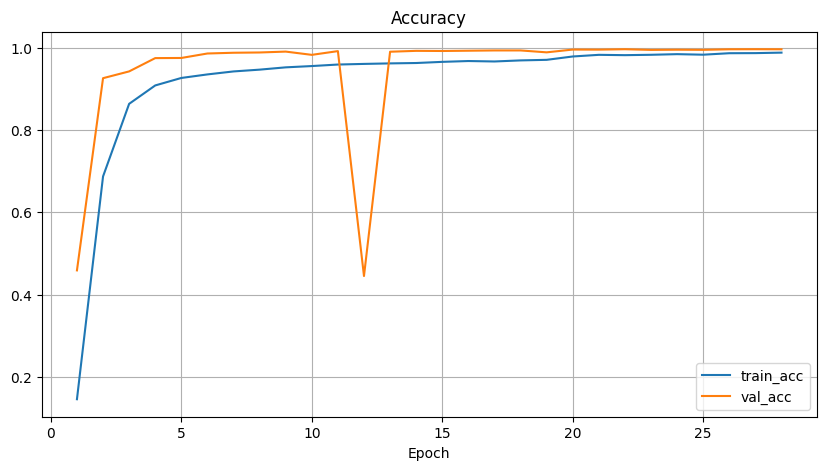

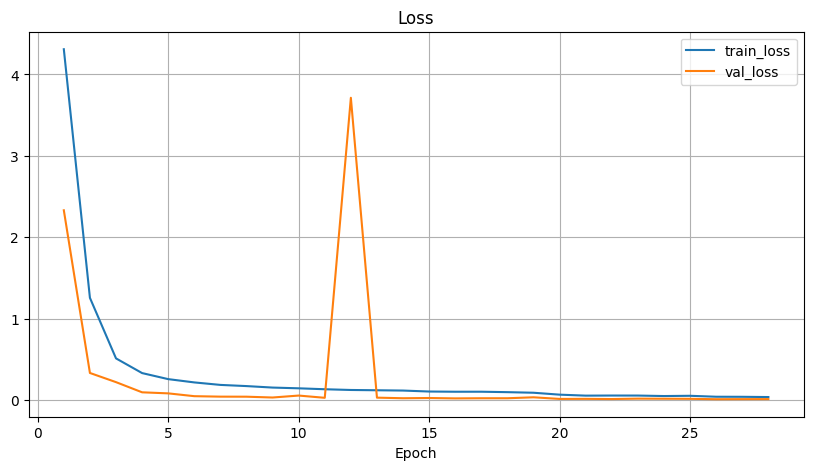

In [ ]:
hist_df = pd.DataFrame(history.history)
epochs = np.arange(1, len(hist_df)+1)

plt.figure(figsize=(10,5))
plt.plot(epochs, hist_df['accuracy'], label='train_acc')
plt.plot(epochs, hist_df['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(epochs, hist_df['loss'], label='train_loss')
plt.plot(epochs, hist_df['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

474/474 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        41
           1     1.0000    1.0000    1.0000        41
           2     1.0000    0.9756    0.9877        41
           3     1.0000    1.0000    1.0000        40
           4     1.0000    1.0000    1.0000        40
           5     1.0000    1.0000    1.0000        40
           6     1.0000    1.0000    1.0000        22
           7     1.0000    1.0000    1.0000        40
           8     1.0000    1.0000    1.0000        40
           9     1.0000    1.0000    1.0000        40
          10     1.0000    0.9756    0.9877        41
          11     1.0000    1.0000    1.0000        40
          12     1.0000    1.0000    1.0000        40
          13     1.0000    1.0000    1.0000        40
          14     1.0000    1.0000    1.0000        40
          15     1.0000    1.0000    1.0000        40
          16   

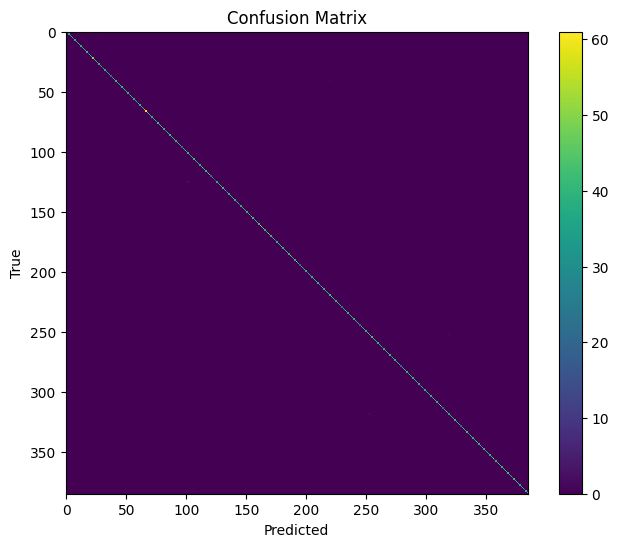

In [ ]:
y_pred_probs = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
cnn_model.save("Gujarati_Word_CNN_Model.keras")